# 2024 CITS4012 Project

# Readme

# 1. Dataset Processing

## Importing Libraries

In [1]:
import re
import json
import time
import math
import spacy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.colors import LinearSegmentedColormap

## Loading Datasets

In [2]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist()
training_a = train_data['aspect'].tolist()
training_y = train_data['polarity'].tolist()
val_x = val_data['sentence'].tolist()
val_a = val_data['aspect'].tolist()
val_y = val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [5]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7090
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

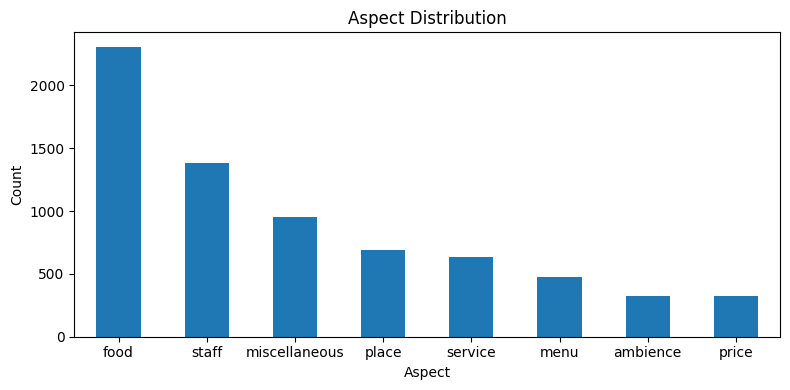

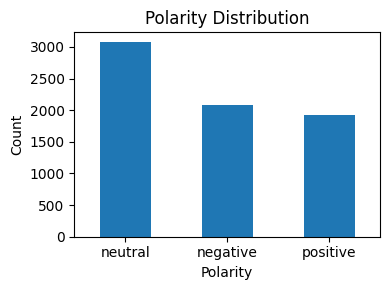

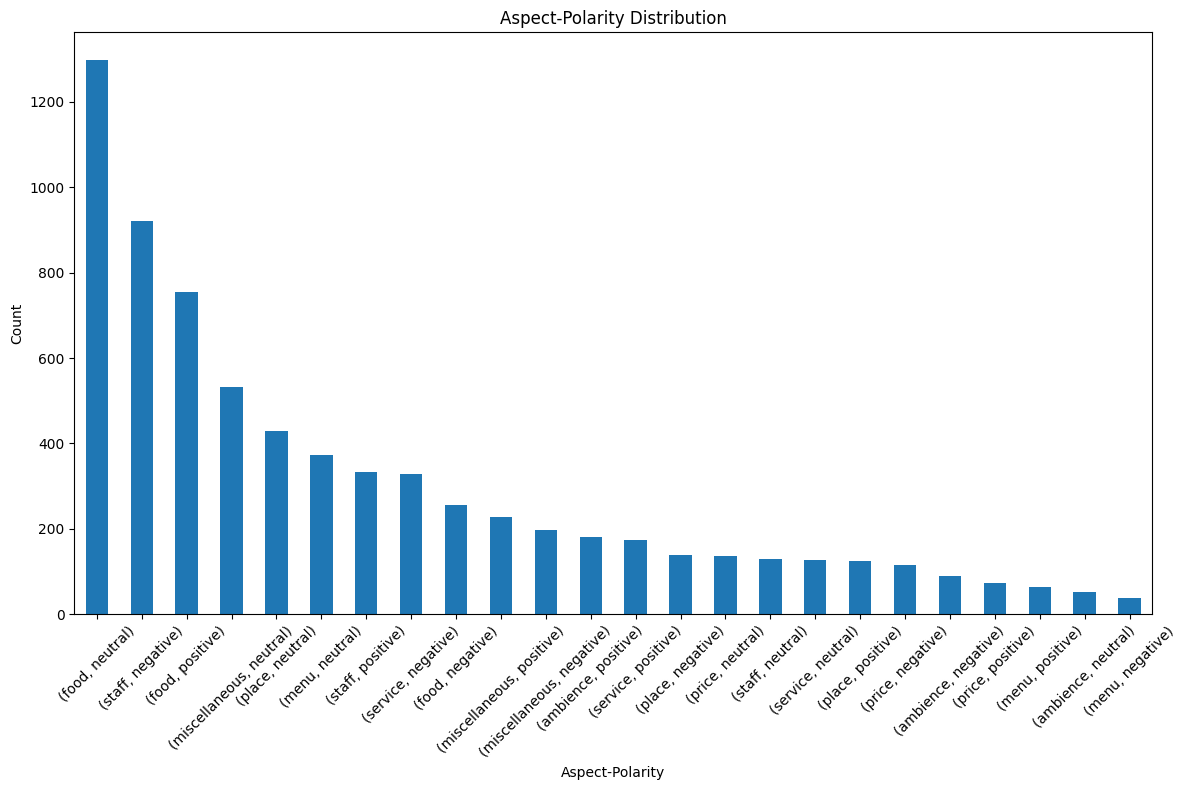

In [6]:
# Function to plot distribution bar graphs
def plot_distribution(figsize, distribution, title, xlabel, rotation=0):
    plt.figure(figsize=figsize)
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot Aspect Distribution
plot_distribution((8, 4), aspect_distribution, 'Aspect Distribution', 'Aspect')
# Plot Polarity Distribution
plot_distribution((4, 3), polarity_distribution, 'Polarity Distribution', 'Polarity')
# Plot Aspect-Polarity Distribution
plot_distribution((12, 8), aspect_polarity_freq, 'Aspect-Polarity Distribution', 'Aspect-Polarity', 45)

## Data Preprocessing

In [7]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 960.0 kB/s eta 0:00:14
      --------------------------------------- 0.2/12.8 MB 2.4 MB/s eta 0:00:06
      --------------------------------------- 0.3/12.8 MB 2.5 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 2.6 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 2.9 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 3.0 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.0 MB/s eta 0:00:04
     ----- ---------------------------------- 1.6/12.8 MB 

In [8]:
# Spacy
nlp = spacy.load("en_core_web_sm")

# Remove certain words from the stop words list
custom_stop_words = [
    "not", "no", "never", "neither", "nor",
    "nobody", "nothing", "nowhere", "none", "cannot"
]

for a in custom_stop_words:
    nlp.vocab[a].is_stop = False

# Perform Stopwords Removal, Lemmatisation and Tokenisation
def spacy_processing(x):
    doc = nlp(x)
    x = [word.lemma_ for word in doc if not word.is_stop]
    return x

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

In [9]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)    # Remove punctuation
        sentence = re.sub(r"\s+", " ", sentence)        # Remove extra spaces
        tokens = spacy_processing(sentence)             # Remove stopwords / Lemmatisation / Tokenise
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)
val_x_token = preprocess_data(val_x)

# Function to append aspect to the end of sentence
def append_aspect(token_list, aspect_list, has_sep):
    output = []
    for tokens, aspect in zip(token_list, aspect_list):
        if has_sep:
            new_tokens = tokens + ['<SEP>'] + [aspect]
        else:
            new_tokens = tokens + [aspect]
        output.append(new_tokens)
    return output

# Append aspect to end of sentence
train_xa_sep_token = append_aspect(train_x_token, training_a, has_sep=True)
test_xa_sep_token = append_aspect(test_x_token, test_a, has_sep=True)
val_xa_sep_token = append_aspect(val_x_token, val_a, has_sep=True)

## Create Word Vocabulary

In [10]:
# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<SEP>': 0, '<PAD>': 1}
review = train_x_token + test_x_token + val_x_token
review_aspect_sep = train_xa_sep_token + test_xa_sep_token + val_xa_sep_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]
MAX_LENGTH = len(max(review, key=len))                # Maximum length of a sentence
MAX_SEP_LENGTH = len(max(review_aspect_sep, key=len)) # Maximum length of a sentence after appending aspect with separator

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
word_list = list(word_to_idx.keys())
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}
polarity_list = list(polarity_to_idx.keys())
num_polarities = len(polarity_to_idx)

## Convert Words to Index form

In [11]:
# Function to convert list of tokens to list of indices (with paddings)
def list_to_index(token_list, word_to_idx, max_seq_length):
    idx_list = []
    for tokens in token_list:
        padded = tokens + ['<PAD>'] * (max_seq_length - len(tokens))
        idx_list.append([word_to_idx[token] for token in padded])
    return idx_list

# Function to convert list of strings to list of indices
def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Function to prepare index lists for datasets
def prepare_index_lists(x_token, a, y, xa_sep_token):
    x_idx = list_to_index(x_token, word_to_idx, MAX_LENGTH)
    a_idx = string_to_index(a, word_to_idx)
    y_idx = string_to_index(y, polarity_to_idx)
    xa_idx = list_to_index(xa_sep_token, word_to_idx, MAX_SEP_LENGTH)
    return x_idx, a_idx, y_idx, xa_idx

# Token index lists for training data (with paddings)
train_x_idx, train_a_idx, train_y_idx, train_xa_idx = prepare_index_lists(
    train_x_token, training_a, training_y, train_xa_sep_token)

# Token index lists for test data (with paddings)
test_x_idx, test_a_idx, test_y_idx, test_xa_idx = prepare_index_lists(
    test_x_token, test_a, test_y, test_xa_sep_token)

# Token index lists for validation data (with paddings)
val_x_idx, val_a_idx, val_y_idx, val_xa_idx = prepare_index_lists(
    val_x_token, val_a, val_y, val_xa_sep_token)

## Pretrained Word Embeddings from Glove

In [12]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100
glove_model = api.load("glove-twitter-100")
glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

# 2. Model Implementation

## Model 1 Architecture (LSTM)

In [13]:
class LSTM(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention, has_aspect='True'):
        super(LSTM, self).__init__()
        self.has_aspect = has_aspect
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        if self.attention_type == ATTN_NONE:
            self.linear = nn.Linear(self.hidden_size, self.output_size)
        else:
            self.linear = nn.Linear(self.hidden_size*2, self.output_size)

    # Attention mechanism
    def attention(self, query, key, masking):
        if self.attention_type == ATTN_NONE:    # No attention
            output = F.softmax(self.linear(key.squeeze()), dim=1)
            return output, _
        elif self.attention_type == ATTN_DOT:   # Dot product attention
            attn_weights = torch.bmm(query, key.permute(1, 2, 0))
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key.permute(1, 2, 0)) * scale
        attn_weights.masked_fill_(masking.unsqueeze(2), float(-1000)) # Ignore padding
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output, attn_weights
    
    # Forward propagation
    def forward(self, input, _):
        sentence_embeddings = self.embedding(input)
        outputs, (hidden, cell) = self.lstm(sentence_embeddings)
        # outputs = [batch_size, seq_length, hidden_size]
        # hidden  = [num_layers=1, batch_size, hidden_size]
        masking = (input==1)
        output, attn_weights = self.attention(outputs, hidden, masking)
        return output, attn_weights

## Model 2 Architecture (IAN)

In [34]:
class IAN(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention):
        super(IAN, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm_aspect = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm_input = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4, self.output_size)
        
    # Attention mechanism
    def attention(self, query, key, masking=None):
        if self.attention_type == ATTN_DOT:     # Dot product attention
            attn_weights = torch.bmm(query, key)
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key) * scale
        if masking is not None:
            attn_weights.masked_fill_(masking.unsqueeze(2), float(-1000)) # Ignore padding
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(2)), dim=1)
        return concat_output, attn_weights

    # Forward propagation
    def forward(self, input, aspect):
        input_length = torch.sum(input!=1, dim=1) # Ignore padding
        input_embeddings = self.embedding(input)
        aspect_embeddings = self.embedding(aspect)
        masking = (input==1)
        
        input, (_, _) = self.lstm_input(input_embeddings)
        aspect, (_, _) = self.lstm_aspect(aspect_embeddings)
        
        aspect_pool = torch.mean(aspect, dim=1)
        input_pool = torch.sum(input, dim=1)
        input_pool = torch.div(input_pool, input_length.view(input_length.size(0), 1))

        input_final, attn_weights = self.attention(input, aspect_pool.unsqueeze(2), masking)
        aspect_final, _ = self.attention(aspect, input_pool.unsqueeze(2))
        # attn_weights for aspect not used = 1.0 for all (only one aspect word)
        
        output = torch.cat((input_final, aspect_final), dim=1)
        output = F.log_softmax(self.linear(output), dim=1)
        return output, attn_weights

## Model 3 Architecture (ATAE-LSTM)

In [41]:
class ATAELSTM(nn.Module):
    # Initialise the model
    def __init__(self, hidden_size, output_size, batch_size, embedding, attention):
        super(ATAELSTM, self).__init__()
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size*2, hidden_size, batch_first=True)
        if self.attention_type == ATTN_NONE:
            self.linear = nn.Linear(self.hidden_size, self.output_size)
        else:
            self.linear = nn.Linear(self.hidden_size*4, self.output_size)
        
    # Attention mechanism
    def attention(self, query, key, masking):
        if self.attention_type == ATTN_NONE:    # No attention
            output = F.softmax(self.linear(key.squeeze()), dim=1)
            return output, _
        elif self.attention_type == ATTN_DOT:   # Dot product attention
            attn_weights = torch.bmm(query, key.permute(1, 2, 0))
        elif self.attention_type == ATTN_SCALE: # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = torch.bmm(query, key.permute(1, 2, 0)) * scale
        attn_weights.masked_fill_(masking.unsqueeze(2), float(-1000)) # Ignore padding
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        attn_output = torch.bmm(attn_weights.unsqueeze(1), query).squeeze(1)
        concat_output = torch.cat((attn_output, key.squeeze(0)), dim=1)
        output = F.log_softmax(self.linear(concat_output), dim=1)
        return output, attn_weights

    # Forward propagation
    def forward(self, input, aspect):
        sentence_embeddings = self.embedding(input)
        aspect_embeddings = self.embedding(aspect)
        reshape_aspect_embeddings = aspect_embeddings.view(self.batch_size, 1, self.hidden_size)
        reshape_aspect_embeddings = reshape_aspect_embeddings.expand(self.batch_size, MAX_LENGTH, self.hidden_size)
        embedded = torch.cat((sentence_embeddings, reshape_aspect_embeddings), dim=-1)
        outputs, (hidden, cell) = self.lstm(embedded)
        outputs = torch.cat((outputs, reshape_aspect_embeddings), dim=-1)
        hidden = torch.cat((hidden, aspect_embeddings.permute(1, 0, 2)), dim=-1)
        masking = (input==1)
        output, attn_weights = self.attention(outputs, hidden, masking)
        return output, attn_weights

## Helper Functions for Training
- asMinutes() : Convert time to minutes
- timeSince() : Calculate time since last checkpoint
- prepare_batch() : Prepare batch tensor data for training

In [16]:
# Function to get time elapsed during training
# Reference: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to prepare data in batches
def prepare_batch(sentences, aspects, polarities, batch_size):
    data = []
    for i in range(len(sentences)):
        x_tensor = torch.LongTensor(sentences[i]).to(device)
        a_tensor = torch.LongTensor([aspects[i]]).to(device)
        y_tensor = torch.LongTensor([polarities[i]]).to(device)
        data.append((x_tensor, a_tensor, y_tensor))
    dataloader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    return dataloader

# Set the random seed for reproducibility
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Function to Train Model
- train() : Train model on training data based on different integration types
- plot_graphs() : Plot average loss or accuracy graph over epochs
- Note: have to run the [Evaluation functions](#evaluation) for Accuracy graph visualisation

In [17]:
# Function to train model
def train(model, batches, batch_size=64, learning_rate=0.001, num_epochs=10000,
          print_interval=500, plot_interval=200, accuracy_graph=False):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    plot_avg_losses, plot_accuracy = [], []
    print_total_loss, plot_total_loss = 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        for i, batch in enumerate(batches):
            (inputs, aspects, targets) = batch
            
            model.train()
            optimizer.zero_grad()
            
            outputs, _ = model(inputs, aspects)
            loss = criterion(outputs, targets.squeeze())
            
            # Backpropogation
            loss.backward()
            optimizer.step()
            
            print_total_loss += loss.item()
            plot_total_loss += loss.item()

        if epoch % print_interval == 0:
            print_avg_loss = print_total_loss / ((i+1)*print_interval)
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_total_loss = 0

        if epoch % plot_interval == 0:
            # Calculate average loss over plot interval
            plot_avg_loss = plot_total_loss / ((i+1)*plot_interval)
            plot_avg_losses.append(plot_avg_loss)
            plot_total_loss = 0

            # Calculate accuracy on validation set
            if accuracy_graph:
                accuracy = evaluate(model, batch_size, is_test=False)
                plot_accuracy.append(accuracy)

    return model, plot_avg_losses, plot_accuracy

# Function to plot average loss or accuracy graph over epochs
def plot_graph(num_epochs, interval, plot_data, title, metric):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1, interval), plot_data)
    plt.title(f'{metric.capitalize()} over Epochs ({title})')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

# 3. Testing and Evaluation

## Functions to Visualise Attention Weights
- plot_attention() : Plot attention weights for a given sentence

In [18]:
# Define custom colormap with Blue as highest values and white as lowest values
colors = [(1, 1, 1), (0.2, 0.4, 1)]  # White to Blue
cmap_name = 'custom_blue_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Function to plot attention weights for a sentence
def plot_attention(words, attention_weights, sentence, aspect, pred_polarity, true_polarity):
    # Create figure and axis
    size = len(words)
    fig, ax = plt.subplots(figsize=(size, 2))
    max_w = max(attention_weights)
    norm = plt.Normalize(vmin=0, vmax=max_w)

    # Plot each word with attention weight as colored box
    for i, (word, weight) in enumerate(zip(words, attention_weights)):
        # Plot word
        ax.text(i, 0.5, word, ha='center', va='center', fontsize=12)
        ax.text(i, 0.8, round(weight, 3), ha='center', va='center', color='black', fontsize=12)
        # Plot colored box above word
        color = custom_cmap(norm(weight))
        rect = plt.Rectangle((i - 0.5, 0.6), 1, 0.4, color=color, ec='black')

        ax.add_patch(rect)

    # Set x-axis and y-axis properties
    ax.set_xlim(-0.5, size - 0.5)

    # Remove x-axis and y-axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide ticks on x-axis and y-axis
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(f'Aspect: {aspect} | Predicted Polarity: {pred_polarity} | True Polarity: {true_polarity}', fontsize=14)

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    ax.text(-1, 0.2, ', '.join(words), ha='left', va='center', fontsize=12)
    ax.text(-1, 0, sentence, ha='left', va='center', fontsize=12)
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.05, right=0.95)

    # Show plot
    plt.show()

## Function to Evaluate Model
- predict() : Predict polarity of a given sentence based on an aspect
- evaluate() : Evaluate model on val/test data and return accuracy
<a id="evaluation"></a>

In [19]:
# Function to get model's prediction on test data
def evaluate_batch(model, inputs, aspects, targets):
    correct = 0
    predicted_polarities = []
    outputs, attn_weights = model(inputs, aspects)
    _, topi = outputs.data.topk(1)
    for output, target in zip(topi, targets):
        predicted = polarity_list[output.item()]
        actual = polarity_list[target.item()]
        predicted_polarities.append(predicted)
        if predicted == actual:
            correct += 1
    return correct, attn_weights, predicted_polarities

# Function to calculate model accuracy on test data
def evaluate(model, batch_size, is_test=True):
    model.eval()
    with torch.no_grad():
        # Prepare batches based on integration type
        if isinstance(model, LSTM):
            sentences = test_xa_idx if is_test else val_xa_idx
        elif isinstance(model, IAN) or isinstance(model, ATAELSTM):
            sentences = test_x_idx if is_test else val_x_idx
        aspects = test_a_idx if is_test else val_a_idx
        polarities = test_y_idx if is_test else val_y_idx
        data_batches = prepare_batch(sentences, aspects, polarities, batch_size)

        # Calculate accuracy
        correct = 0
        for (inputs, aspects, targets) in data_batches:
            batch_correct, _, _ = evaluate_batch(model, inputs, aspects, targets)
            correct += batch_correct
        accuracy = correct / len(test_data)
    return accuracy

# Run Models

## Selected Hyperparameters

In [36]:
# Different attention mechanisms
ATTN_NONE     = 'no_attention'
ATTN_DOT      = 'dot_product'
ATTN_SCALE    = 'scaled_dot_product'

# Set hyperparameters
num_epochs     = 30
print_interval = 1
plot_interval  = 1
batch_size     = 32
hidden_size    = 100
learning_rate  = 0.001
attention_type = ATTN_DOT

# Prepare batches for training
seed = 3456
set_random_seed(seed) # For reproducibility
batches = prepare_batch(train_x_idx, train_a_idx, train_y_idx, batch_size)
sep_batches = prepare_batch(train_xa_idx, train_a_idx, train_y_idx, batch_size)

## Model 0 - No aspect integration

In [37]:
# # Get word embeddings
# embedding = nn.Embedding(vocab_size, hidden_size)
# embedding.weight.data.copy_(torch.from_numpy(glove_weights))

# set_random_seed(seed) # For reproducibility
# model0 = LSTM(hidden_size, num_polarities, batch_size, embedding, attention_type, has_aspect=False).to(device)
# model0, plot_avg_losses0, plot_accuracy0 = train(model0, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
#                                                  print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=False)

# accuracy0 = evaluate(model0, batch_size)
# print(f"Accuracy for Model0: {accuracy0:.4f}")
# plot_graph(num_epochs, plot_interval, plot_avg_losses0, 'Model0 Average Loss over Epochs', 'Loss')
# # plot_graph(num_epochs, plot_interval, plot_accuracy0, 'Model0 Accuracy over Epochs', 'Accuracy')

## Model 1 - Append aspect to the end of sentence

0m 0s (- 0m 20s) Epoch [1/30] Loss: 0.9574
0m 1s (- 0m 19s) Epoch [2/30] Loss: 0.8880
0m 2s (- 0m 18s) Epoch [3/30] Loss: 0.7949
0m 2s (- 0m 18s) Epoch [4/30] Loss: 0.7324
0m 3s (- 0m 17s) Epoch [5/30] Loss: 0.6832
0m 4s (- 0m 16s) Epoch [6/30] Loss: 0.6384
0m 4s (- 0m 15s) Epoch [7/30] Loss: 0.5983
0m 5s (- 0m 14s) Epoch [8/30] Loss: 0.5515
0m 6s (- 0m 14s) Epoch [9/30] Loss: 0.5007
0m 6s (- 0m 13s) Epoch [10/30] Loss: 0.4589
0m 7s (- 0m 12s) Epoch [11/30] Loss: 0.4129
0m 7s (- 0m 11s) Epoch [12/30] Loss: 0.3703
0m 8s (- 0m 11s) Epoch [13/30] Loss: 0.3379
0m 9s (- 0m 10s) Epoch [14/30] Loss: 0.2915
0m 9s (- 0m 9s) Epoch [15/30] Loss: 0.2734
0m 10s (- 0m 8s) Epoch [16/30] Loss: 0.2417
0m 10s (- 0m 8s) Epoch [17/30] Loss: 0.2181
0m 11s (- 0m 7s) Epoch [18/30] Loss: 0.1867
0m 11s (- 0m 6s) Epoch [19/30] Loss: 0.1751
0m 12s (- 0m 6s) Epoch [20/30] Loss: 0.1564
0m 13s (- 0m 5s) Epoch [21/30] Loss: 0.1406
0m 13s (- 0m 4s) Epoch [22/30] Loss: 0.1226
0m 14s (- 0m 4s) Epoch [23/30] Loss: 0.112

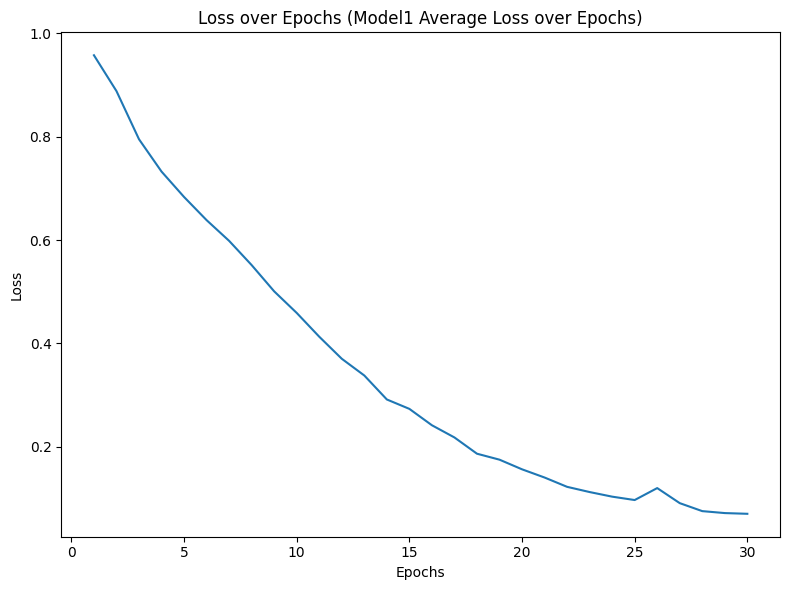

In [38]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

set_random_seed(seed) # For reproducibility
model1 = LSTM(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model1, plot_avg_losses1, plot_accuracy1 = train(model1, sep_batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=False)

accuracy1 = evaluate(model1, batch_size)
print(f"Accuracy for Model1: {accuracy1:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses1, 'Model1 Average Loss over Epochs', 'Loss')
# plot_graph(num_epochs, plot_interval, plot_accuracy1, 'Model1 Accuracy over Epochs', 'Accuracy')

## Model 2 - IAN

0m 1s (- 0m 33s) Epoch [1/30] Loss: 0.8720
0m 2s (- 0m 31s) Epoch [2/30] Loss: 0.7663
0m 3s (- 0m 30s) Epoch [3/30] Loss: 0.6893
0m 4s (- 0m 29s) Epoch [4/30] Loss: 0.5951
0m 5s (- 0m 28s) Epoch [5/30] Loss: 0.4974
0m 6s (- 0m 27s) Epoch [6/30] Loss: 0.3928
0m 7s (- 0m 25s) Epoch [7/30] Loss: 0.2931
0m 8s (- 0m 24s) Epoch [8/30] Loss: 0.2061
0m 9s (- 0m 22s) Epoch [9/30] Loss: 0.1466
0m 10s (- 0m 21s) Epoch [10/30] Loss: 0.0987
0m 11s (- 0m 20s) Epoch [11/30] Loss: 0.0729
0m 12s (- 0m 18s) Epoch [12/30] Loss: 0.0482
0m 13s (- 0m 17s) Epoch [13/30] Loss: 0.0312
0m 14s (- 0m 16s) Epoch [14/30] Loss: 0.0251
0m 15s (- 0m 15s) Epoch [15/30] Loss: 0.0236
0m 16s (- 0m 14s) Epoch [16/30] Loss: 0.0122
0m 17s (- 0m 13s) Epoch [17/30] Loss: 0.0084
0m 18s (- 0m 12s) Epoch [18/30] Loss: 0.0041
0m 19s (- 0m 11s) Epoch [19/30] Loss: 0.0029
0m 20s (- 0m 10s) Epoch [20/30] Loss: 0.0024
0m 21s (- 0m 9s) Epoch [21/30] Loss: 0.0018
0m 22s (- 0m 8s) Epoch [22/30] Loss: 0.0014
0m 23s (- 0m 7s) Epoch [23/30]

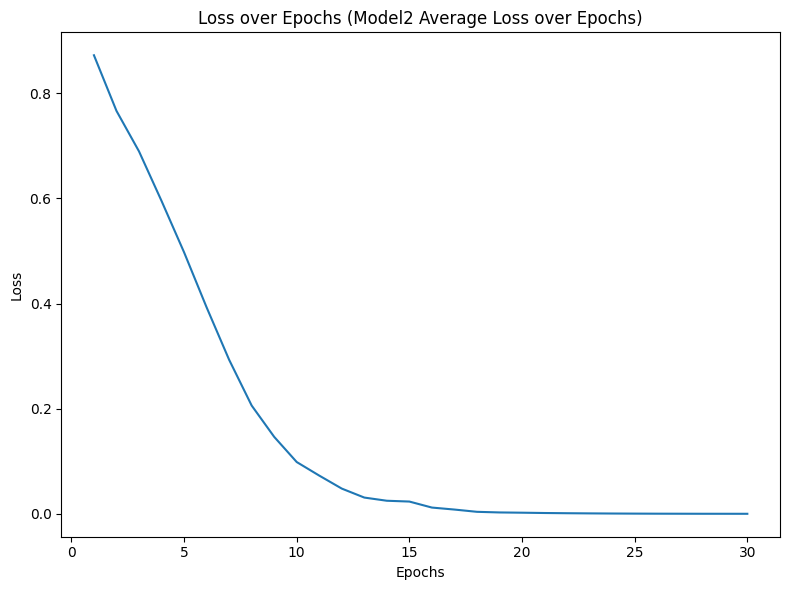

In [39]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

set_random_seed(seed) # For reproducibility
model2 = IAN(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model2, plot_avg_losses2, plot_accuracy2 = train(model2, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=False)

accuracy2 = evaluate(model2, batch_size)
print(f"Accuracy for Model2: {accuracy2:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses2, 'Model2 Average Loss over Epochs', 'Loss')
# plot_graph(num_epochs, plot_interval, plot_accuracy2, 'Model2 Accuracy over Epochs', 'Accuracy')

## Model 3 - Concatenate aspect embeddings to word embeddings + concatenate aspect embeddings into sentence hidden representations

0m 0s (- 0m 23s) Epoch [1/30] Loss: 0.8797
0m 1s (- 0m 20s) Epoch [2/30] Loss: 0.7778
0m 2s (- 0m 19s) Epoch [3/30] Loss: 0.6920
0m 2s (- 0m 18s) Epoch [4/30] Loss: 0.6071
0m 3s (- 0m 18s) Epoch [5/30] Loss: 0.5164
0m 4s (- 0m 17s) Epoch [6/30] Loss: 0.4325
0m 5s (- 0m 17s) Epoch [7/30] Loss: 0.3490
0m 5s (- 0m 16s) Epoch [8/30] Loss: 0.2765
0m 6s (- 0m 15s) Epoch [9/30] Loss: 0.2136
0m 7s (- 0m 14s) Epoch [10/30] Loss: 0.1559
0m 8s (- 0m 14s) Epoch [11/30] Loss: 0.1162
0m 9s (- 0m 13s) Epoch [12/30] Loss: 0.0901
0m 9s (- 0m 12s) Epoch [13/30] Loss: 0.1013
0m 10s (- 0m 12s) Epoch [14/30] Loss: 0.0495
0m 11s (- 0m 11s) Epoch [15/30] Loss: 0.0428
0m 12s (- 0m 10s) Epoch [16/30] Loss: 0.0458
0m 13s (- 0m 10s) Epoch [17/30] Loss: 0.0459
0m 13s (- 0m 9s) Epoch [18/30] Loss: 0.0608
0m 14s (- 0m 8s) Epoch [19/30] Loss: 0.0309
0m 15s (- 0m 7s) Epoch [20/30] Loss: 0.0152
0m 16s (- 0m 6s) Epoch [21/30] Loss: 0.0075
0m 16s (- 0m 6s) Epoch [22/30] Loss: 0.0057
0m 17s (- 0m 5s) Epoch [23/30] Loss: 

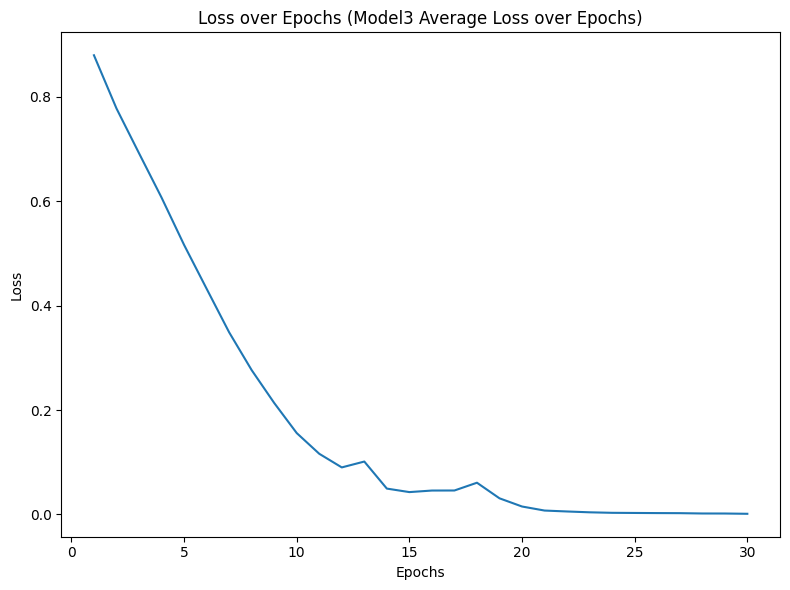

In [42]:
# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))

set_random_seed(seed) # For reproducibility
model3 = ATAELSTM(hidden_size, num_polarities, batch_size, embedding, attention_type).to(device)
model3, plot_avg_losses3, plot_accuracy3 = train(model3, batches, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs,
                                                 print_interval=print_interval, plot_interval=plot_interval, accuracy_graph=False)

accuracy3 = evaluate(model3, batch_size)
print(f"Accuracy for Model3: {accuracy3:.4f}")
plot_graph(num_epochs, plot_interval, plot_avg_losses3, 'Model3 Average Loss over Epochs', 'Loss')
# plot_graph(num_epochs, plot_interval, plot_accuracy3, 'Model3 Accuracy over Epochs', 'Accuracy')

## Visualisation of Attention Weights

In [43]:
a = "The place was empty with three waiters working and it still took 15 minutes to bring us menus." # 117, 118, 119
b = "Our waitress kept forgetting our drinks." # 120, 121
c = "the service was horrible then and the food was decent." # 122, 123
print(test_x.index(a))
print(test_x.index(b))
print(test_x.index(c))

117
120
122


In [44]:
# Function to append data to the list according to given indices
def append_data(model, indices, data):
    for idx in indices:
        if isinstance(model, LSTM):
            x_tensor = torch.LongTensor(test_xa_idx[idx]).to(device)
        elif isinstance(model, IAN) or isinstance(model, ATAELSTM):
            x_tensor = torch.LongTensor(test_x_idx[idx]).to(device)
        a_tensor = torch.LongTensor([test_a_idx[idx]]).to(device)
        y_tensor = torch.LongTensor([test_y_idx[idx]]).to(device)
        data.append((x_tensor, a_tensor, y_tensor))
    return data

# Function to prepare custom batch for visualisation
def prepare_custom_batch(model, indices, batch_size):
    data = append_data(model, indices, [])
    remaining_indices = list(range(len(test_x)))
    remaining_indices = [i for i in remaining_indices if i not in indices]
    batch_indices = np.random.choice(remaining_indices, size=batch_size-len(indices), replace=True)
    data = append_data(model, batch_indices, data)

    custom_batch = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
    return custom_batch

# Function to visualise the attention weights for a sentence
def visualise_sentence(model, indices, batch_size):
    custom_size = len(indices)
    reviews = [test_x[i] for i in indices]
    dataset = prepare_custom_batch(model, indices, batch_size)
    sentences, aspects, polarities = list(dataset)[0]
    words = [[idx_to_word[i] for i in sentence.tolist() if i != 1] for sentence in sentences[:custom_size]]
    _, attn_weights, pred_polarities = evaluate_batch(model, sentences, aspects, polarities)
    weights = [w.tolist() for w in attn_weights[:custom_size]]
    outputs = pred_polarities[:custom_size]
    aspects = [idx_to_word[aspects[i].item()] for i in range(custom_size)]
    targets = [idx_to_polarity[polarities[i].item()] for i in range(custom_size)]
    for i in range(custom_size):
        plot_attention(words[i], weights[i], reviews[i], aspects[i], outputs[i], targets[i])
        
# Test sample instances
indices = [2, 3, 528, 529, 530, 117, 118, 119, 120, 121, 122, 123]

Visualising Attention Weights for Model2:


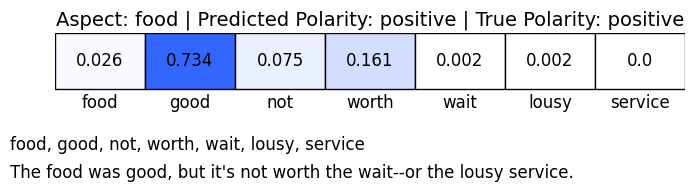

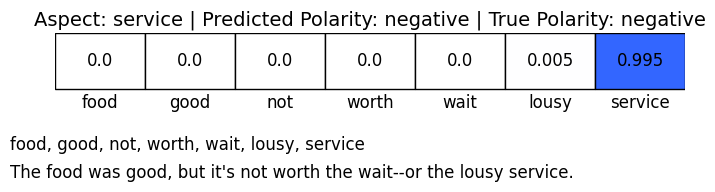

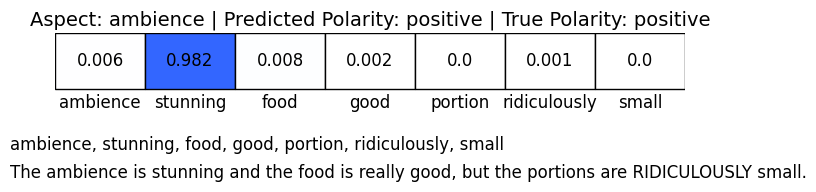

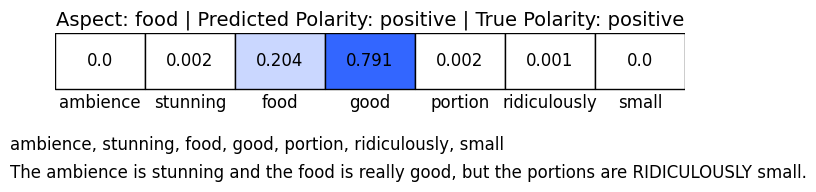

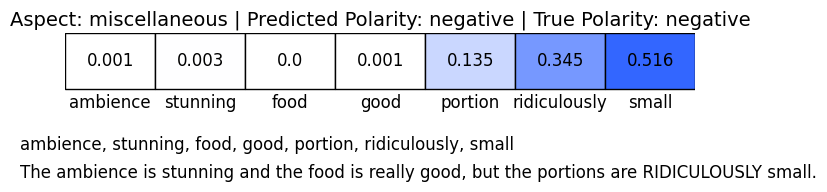

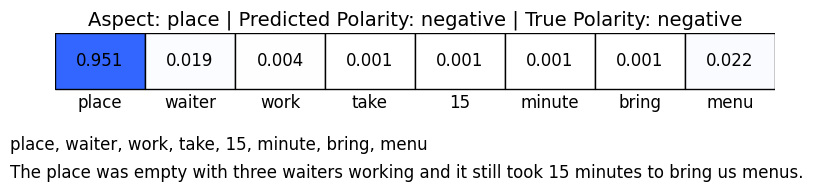

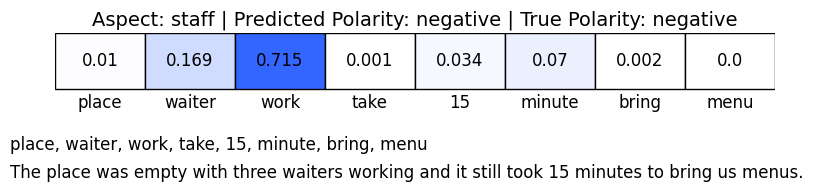

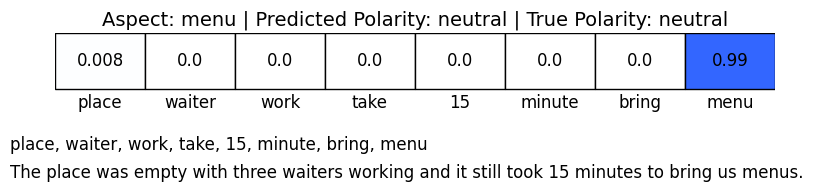

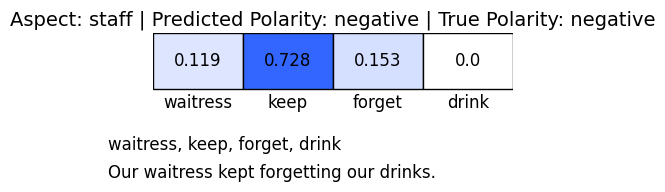

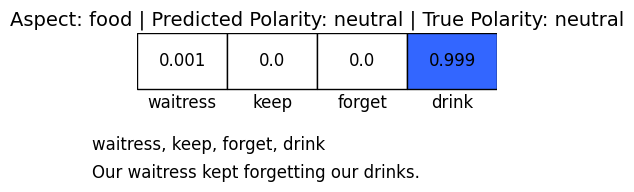

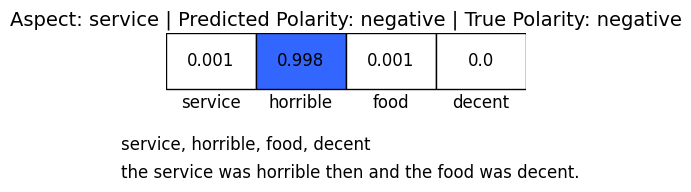

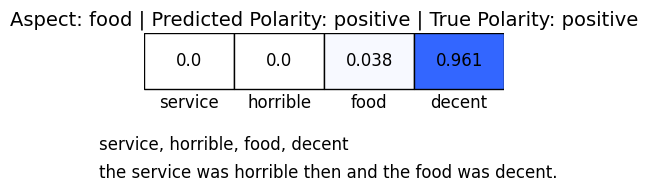

In [45]:
# Visualise the attention weights for the sample instances
# print("Visualising Attention Weights for Model1:")
# visualise_sentence(model1, indices, batch_size)
print("Visualising Attention Weights for Model2:")
visualise_sentence(model2, indices, batch_size)
# print("Visualising Attention Weights for Model3:")
# visualise_sentence(model3, indices, batch_size)